In [ ]:
!pip install torchdiffeq

In [2]:
import torch
print(torch.cuda.is_available())   # True여야 GPU 사용 가능
print(torch.cuda.device_count())   # GPU 개수
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
NVIDIA A100-SXM4-40GB


In [ ]:
import torch
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)                  # Python random 고정
    np.random.seed(seed)               # Numpy random 고정
    torch.manual_seed(seed)            # PyTorch CPU 고정
    torch.cuda.manual_seed(seed)       # PyTorch GPU 단일 고정

    # 연산 재현성 보장 (속도는 약간 손해봄)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # [-1,1] 범위
    #transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
subset = Subset(train_dataset, range(1000))
train_loader = DataLoader(subset, batch_size=4, shuffle=True)

val_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_subset = Subset(val_dataset, range(500))
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False)

dim = 32*32*3  # 3072

# --------------------------------------
# 2. 벡터장 모델
# --------------------------------------
# CNN 기반 Vector Field
class ConvVectorField(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3+1, hidden_dim, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, hidden_dim*2, 3, stride=2, padding=1)

        # Bottleneck
        self.res1 = nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1)
        self.res2 = nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(hidden_dim*2, hidden_dim*2, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=2, padding=1)
        self.conv_out = nn.Conv2d(hidden_dim, 3, 3, stride=1, padding=1)

    def forward(self, x, t):
        # x: (B, 3, 32, 32), t: (B,1)
        B, _, H, W = x.shape
        xt = torch.cat([x, t], dim=1)         # (B, 4, 32, 32)

        # Encoder
        h = F.relu(self.conv1(xt))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))

        # Bottleneck (Residual style)
        h = F.relu(self.res1(h)) + h
        h = F.relu(self.res2(h)) + h

        # Decoder
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        out = self.conv_out(h)   # (B,3,32,32)
        return out


# --------------------------------------
# 3. Flow Matching Loss
# --------------------------------------
def flow_matching_loss(model, x0, x1, t):
    xt = (1 - t) * x0 + t * x1   # (B,3,32,32)
    ut_target = x1 - x0
    input_t = t.mean(dim=1, keepdim=True)
    ut_pred = model(xt, input_t)       # CNN 결과도 (B,3,32,32)
    return ((ut_pred - ut_target) ** 2).mean()

# --------------------------------------
# 4. 학습 루프
# --------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvVectorField(dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

epochs = 100
losses = []
val_losses = []
accumulation_steps = 4

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(epochs):
    for batch_idx, (images, _) in enumerate(train_loader):
        x1 = images.to(device)                    # target = CIFAR image
        x0 = torch.randn_like(x1).to(device)      # source = Gaussian
        t = torch.rand(x1.shape[0], 1).to(device)     # time ∈ [0,1]
        t = t.view(-1, 1, 1, 1).expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])

        loss = flow_matching_loss(model, x0, x1, t)

        loss = loss / accumulation_steps
        loss.backward()

        # 🔹 일정 step마다 optimizer 갱신
        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    losses.append(loss.item())

    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            x1 = images.to(device)
            x0 = torch.randn_like(x1).to(device)
            t = torch.rand(x1.shape[0], 1).to(device)
            t = t.view(-1, 1, 1, 1).expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])
            val_loss = flow_matching_loss(model, x0, x1, t)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # 🔹 Best checkpoint 저장 (val_loss 기준)
    if epoch == 0:
        best_val_loss = avg_val_loss

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        ckpt_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss.item(),
        "val_loss": avg_val_loss,
        }, ckpt_path)
        print(f"✅ Best model updated at epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")

# Loss 곡선 그리기
plt.plot(losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Epoch 1, Loss: 1.1818
Epoch 2, Loss: 0.7926
✅ Best model updated at epoch 2 | Val Loss: 0.6285
Epoch 3, Loss: 0.5847
✅ Best model updated at epoch 3 | Val Loss: 0.3663
Epoch 4, Loss: 0.3998
✅ Best model updated at epoch 4 | Val Loss: 0.3316
Epoch 5, Loss: 0.4386
✅ Best model updated at epoch 5 | Val Loss: 0.3069
Epoch 6, Loss: 0.2632
✅ Best model updated at epoch 6 | Val Loss: 0.2867
Epoch 7, Loss: 0.2128
✅ Best model updated at epoch 7 | Val Loss: 0.2782
Epoch 8, Loss: 0.3029
Epoch 9, Loss: 0.1999
✅ Best model updated at epoch 9 | Val Loss: 0.2772
Epoch 10, Loss: 0.2335
✅ Best model updated at epoch 10 | Val Loss: 0.2652
Epoch 11, Loss: 0.2934
Epoch 12, Loss: 0.1768
✅ Best model updated at epoch 12 | Val Loss: 0.2498
Epoch 13, Loss: 0.1870
✅ Best model updated at epoch 13 | Val Loss: 0.2494
Epoch 14, Loss: 0.2417
Epoch 15, Loss: 0.2165
Epoch 16, Loss: 0.2065


KeyboardInterrupt: 

In [4]:
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
with torch.no_grad():
    total_loss = 0
    count = 0
    for images, _ in test_loader:
        x1 = images.to(device)
        x0 = torch.randn_like(x1).to(device)
        t = torch.rand(len(x1), 1).to(device)
        t = t.view(-1, 1, 1, 1).expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])

        loss = flow_matching_loss(model, x0, x1, t)
        total_loss += loss.item() * len(x1)
        count += len(x1)
    print("Test Loss:", total_loss / count)

Test Loss: 0.25423524105548856


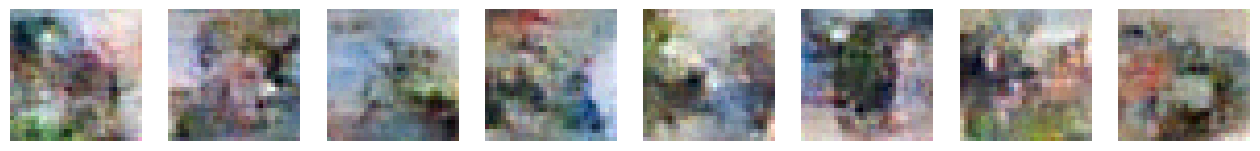

In [5]:
from torchdiffeq import odeint

def sample_images(model, n_samples=16, steps=20, device="cuda"):
    model.eval()
    with torch.no_grad():
        x = torch.randn(n_samples, 3, 32, 32).to(device)

        def ode_func(t, x_flat):
            x = x_flat.view(n_samples, 3, 32, 32)
            t_tensor = torch.full((n_samples,1), t.item(), device=device)
            t_tensor = t_tensor.view(-1,1,1,1).expand(x.shape[0],1,x.shape[2],x.shape[3])
            dx = model(x, t_tensor)   # (B,3,32,32)
            return dx.view(-1)        # flatten

        ts = torch.linspace(0,1,steps).to(device)
        x_final = odeint(ode_func, x.view(-1), ts)
        x_final = x_final[-1].view(n_samples, 3, 32, 32)

    return x_final.cpu()

import matplotlib.pyplot as plt
samples = sample_images(model, n_samples=8)

fig, axes = plt.subplots(1, 8, figsize=(16,2))
for i, ax in enumerate(axes):
    img = samples[i].permute(1,2,0).numpy()
    img = (img - img.min())/(img.max()-img.min())  # normalize to [0,1]
    ax.imshow(img)
    ax.axis("off")
plt.show()

# **Model load**

In [ ]:
ckpt = torch.load("./checkpoints/checkpoint_epoch_100.pth", map_location=device)

model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
start_epoch = ckpt["epoch"]
print(f"🔄 Resumed from epoch {start_epoch}, last loss = {ckpt['loss']:.4f}")